In [3]:
import copy

from transformers import AutoProcessor, AutoModelForCausalLM
from PIL import Image
import requests

import utils
import os
import torch

%matplotlib inline

In [4]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [6]:
model_id = 'microsoft/Florence-2-large'
model = AutoModelForCausalLM.from_pretrained(model_id, trust_remote_code=True).eval().cuda()
processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)
utils.set_model_info(model, processor)

/home/akudaeva/projects/distance-vlm/venv/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [33]:
path = "image2.webp"
image = Image.open(path)
image_rgb = Image.open(path).convert("RGB")

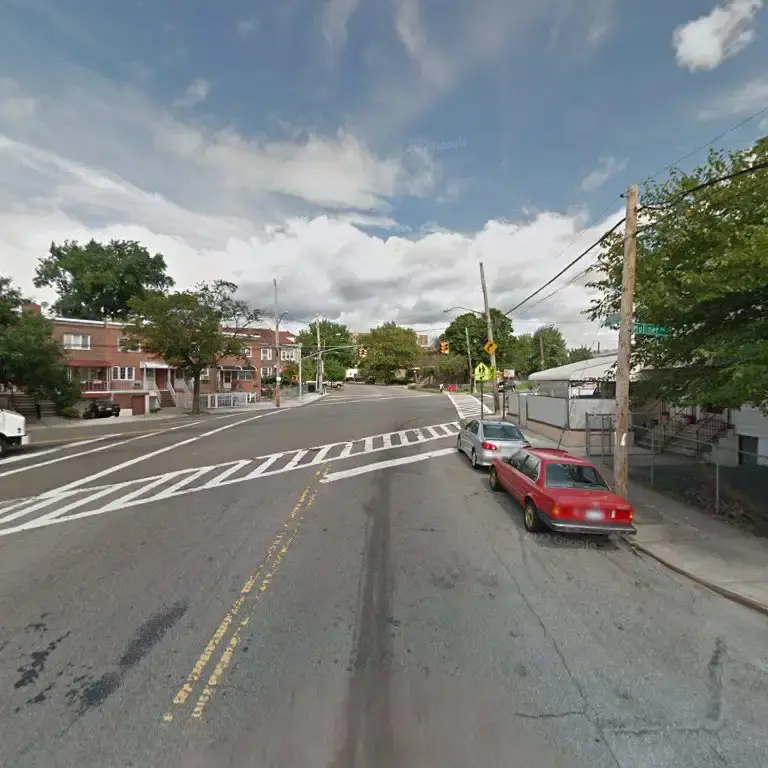

In [34]:
image

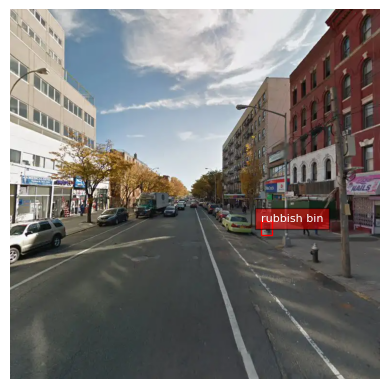

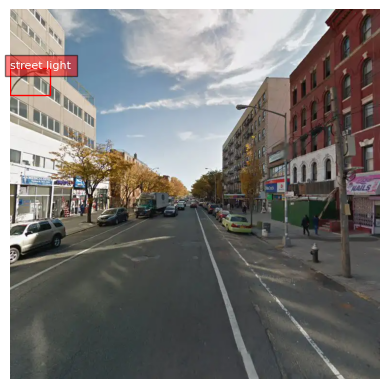

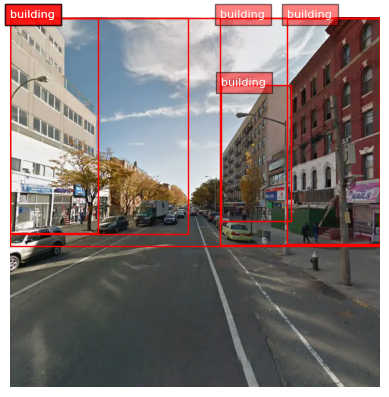

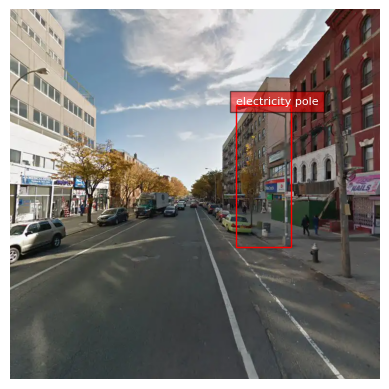

In [9]:
task = utils.TaskType.OPEN_VOCAB_DETECTION

test_labels = ['rubbish bin', 'street light', 'building', 'electricity pole']
for label in test_labels:
    results = utils.run_example(task, image_rgb, text_input = label)
    bbox_results  = utils.convert_to_od_format(results[utils.TaskType.OPEN_VOCAB_DETECTION])
    #print(bbox_results)
    utils.plot_bbox(bbox_results, image)

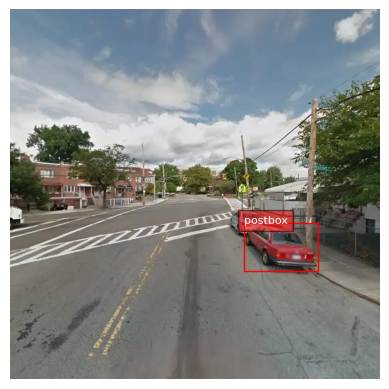

In [35]:
label = "postbox"
results = utils.run_example(task, image_rgb, text_input = label)
bbox_results  = utils.convert_to_od_format(results[utils.TaskType.OPEN_VOCAB_DETECTION])
#print(bbox_results)
utils.plot_bbox(bbox_results, image)

# Confirm result with CLIP

In [ ]:
from transformers import CLIPProcessor, CLIPModel

In [14]:
# Load the CLIP model and processor
model_name = "openai/clip-vit-base-patch32"
model = CLIPModel.from_pretrained(model_name)
processor = CLIPProcessor.from_pretrained(model_name)


In [29]:
def classify_image(image, labels):
    """
    Classify an image using CLIP and a list of labels.

    Args:
        image_path (str): Path to the image file.
        labels (list): List of string labels.

    Returns:
        dict: Label-to-score mapping.
    """
    # Load and preprocess the image
    #image = Image.open(image_path).convert("RGB")
    inputs = processor(text=labels, images=image, return_tensors="pt", padding=True)

    # Perform inference
    outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image  # Shape: [1, num_labels]
    probs = logits_per_image.softmax(dim=1)  # Convert logits to probabilities

    # Map labels to probabilities
    scores = {label: prob.item() for label, prob in zip(labels, probs[0])}
    return scores


In [37]:
x_min, y_min, x_max, y_max = bbox_results['bboxes'][0]
# Crop the image
cropped_image = image.crop((x_min, y_min, x_max, y_max))

# List of labels to classify the image
labels = ["postbox", "car",  "other"]

# Classify the image
scores = classify_image(cropped_image, labels)

# Print results
print("Classification Results:")
for label, score in sorted(scores.items(), key=lambda x: x[1], reverse=True):
    print(f"{label}: {score:.4f}")

Classification Results:
car: 0.9938
other: 0.0045
postbox: 0.0016
